# Init


In [1]:
import os

# Caminho base no HD externo onde salvar caches e modelos
hf_cache_base = '/media/unjun/JU/huggingface_cache'
os.makedirs(hf_cache_base, exist_ok=True)
os.environ['HF_HOME'] = hf_cache_base
os.environ['HUGGINGFACE_HUB_CACHE'] = hf_cache_base
os.environ['TRANSFORMERS_CACHE'] = os.path.join(hf_cache_base, 'transformers')
os.environ['HF_DATASETS_CACHE'] = os.path.join(hf_cache_base, 'datasets')
os.environ['XDG_CACHE_HOME'] = os.path.join(hf_cache_base, 'xdg_cache')
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# ================= REMOVA A SEÇÃO ACIMA SE NÃO ESTIVER USANDO HD EXTERNO ==================

import torch
import gc
import numpy as np

from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel
from diffusers import BitsAndBytesConfig
from transformers import CLIPTextModel, CLIPTextModelWithProjection
from transformers import BitsAndBytesConfig as TransformersBitsAndBytesConfig
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel
from controlnet_aux import OpenposeDetector
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline


/home/unjun/Desktop/VSCode/MC949/T4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/unjun/Desktop/VSCode/MC949/T4/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/unjun/Desktop/VSCode/MC949/T4/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/unjun/Desktop/VSCode/MC949/T4/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__

In [2]:
# Função para limpar memória (CORRIGIDA)
def clear_memory_safe():
    """Função de limpeza que não afeta o pipeline atual"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Memória GPU livre: {torch.cuda.get_device_properties(0).total_memory / 1024**3 - torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    else:
        print("CUDA não disponível")

# Verificar se pipeline já existe
if 'pipeline' in locals() or 'pipeline' in globals():
    print("Pipeline já existe. Removendo...")
    if 'pipeline' in globals():
        del globals()['pipeline']
    if 'pipeline' in locals():
        del pipeline
    gc.collect()
    torch.cuda.empty_cache()

clear_memory_safe()

Memória GPU livre: 3.68 GB


# Stable Diffusion XL (Não funciona com ControlNet na minha máquina, mas podem tentar)

In [ ]:
# --- CONFIGURAÇÕES ---
ckpt_id = "stabilityai/stable-diffusion-xl-base-1.0"
lora_path = "results"
bnb_4bit_compute_dtype = torch.float16

# ControlNet 
controlnet_id = "xinsir/controlnet-openpose-sdxl-1.0"
ref_image = "pose.png"

# Quantização
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

quant_config = TransformersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=bnb_4bit_compute_dtype,
)

# --- PIPELINE ---
try:
    print("Iniciando carregamento do pipeline...")
    print("Carregando componentes...")
    
    # 1. Preparar o Modelo ControlNet
    print("1. Carregando ControlNet Model...")
    controlnet = ControlNetModel.from_pretrained(
        controlnet_id,
        torch_dtype=torch.float16,
        nf4_config=nf4_config
    )

    # 2. Preparar o Pré-processador e o Mapa de Controle
    print("2. Carregando pré-processador OpenPose...")
    pose_processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
    
    # Gerar o Mapa de Pose a partir da imagem de referência
    print(f"   Lendo imagem de referência: {ref_image}")
    input_image = Image.open(ref_image).convert("RGB")
    control_image = pose_processor(input_image)

    print("3. Re-carregando componentes para a Pipeline de Controle...")

    # Recarrega UNet quantizada
    unet = UNet2DConditionModel.from_pretrained(
        ckpt_id, subfolder="unet", quantization_config=nf4_config, torch_dtype=torch.float16
    )
    
    # Recarrega Text Encoders quantizados
    text_encoder = CLIPTextModel.from_pretrained(
        ckpt_id, subfolder="text_encoder", quantization_config=quant_config, torch_dtype=torch.float16
    )
    text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(
        ckpt_id, subfolder="text_encoder_2", quantization_config=quant_config, torch_dtype=torch.float16
    )

    pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
        ckpt_id,
        unet=unet,
        controlnet=controlnet, 
        text_encoder=text_encoder,
        text_encoder_2=text_encoder_2,
        torch_dtype=bnb_4bit_compute_dtype
    )

    # Limpar componentes individuais
    del text_encoder, text_encoder_2, unet, controlnet
    clear_memory_safe() 
    
    # Aplicar otimizações e mover para GPU
    print("4. Aplicando otimizações e movendo para GPU...")
    pipeline.enable_attention_slicing("max")
    pipeline.enable_vae_slicing()
    pipeline.enable_vae_tiling()
    pipeline.enable_model_cpu_offload()

    # Configurações CUDA
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


    # Mover o modelo ControlNet (que não estava quantizado) para a GPU
    # pipeline_control.to("cuda")

    print("✅ Pipeline de Controle carregado e otimizado com sucesso!")

except Exception as e:
    print(f"❌ Erro na integração do ControlNet: {e}")
    clear_memory_safe()

Iniciando carregamento do pipeline...
Carregando componentes...
1. Carregando ControlNet Model...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


Iniciando carregamento do pipeline...
Carregando componentes...
1. Carregando ControlNet Model...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 26.18it/s]



Iniciando carregamento do pipeline...
Carregando componentes...
1. Carregando ControlNet Model...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 26.18it/s]



Memória GPU livre: 1.28 GB
4. Aplicando otimizações e movendo para GPU...
✅ Pipeline de Controle carregado e otimizado com sucesso!
✅ Pipeline de Controle carregado e otimizado com sucesso!


In [ ]:
image = pipeline(
    prompt="An astronaut",
    image=control_image, 
    num_inference_steps=10,  # Reduzido de 25 para 20
    guidance_scale=3.5,
    controlnet_conditioning_scale=0.35,
    width=256,
    height=256 
).images[0]

image

  0%|          | 0/10 [00:02<?, ?it/s]



  0%|          | 0/10 [00:02<?, ?it/s]



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 46.44 MiB is free. Including non-PyTorch memory, this process has 3.21 GiB memory in use. Of the allocated memory 3.07 GiB is allocated by PyTorch, and 21.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

100%|██████████| 28/28 [00:11<00:00,  2.47it/s]


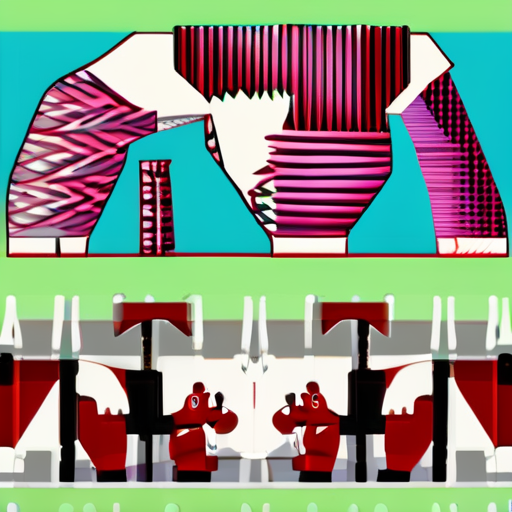

In [4]:
pipeline.unload_lora_weights()

image = pipeline(
    "A red elephant, yarn style", num_inference_steps=28, guidance_scale=3.5, height=512, width=512
).images[0]
image

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
100%|██████████| 28/28 [00:13<00:00,  2.02it/s]


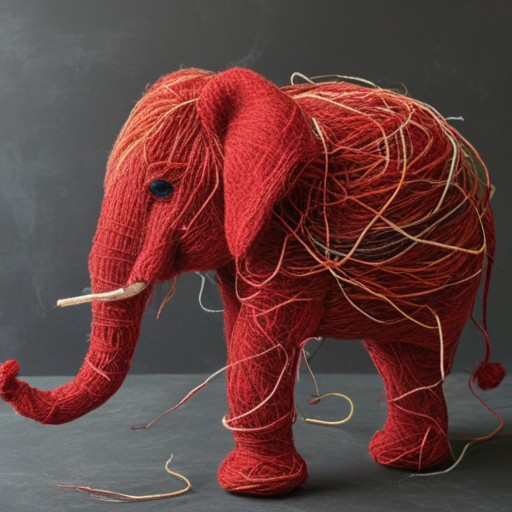

In [5]:
pipeline.load_lora_weights("results", weight_name="pytorch_lora_weights.safetensors")

image = pipeline(
    "A red elephant, yarn style", num_inference_steps=28, guidance_scale=3.5, height=512, width=512
).images[0]
image

# Stable Diffusion v1-5


In [ ]:
# --- CONFIGURAÇÕES ---
ckpt_id = "runwayml/stable-diffusion-v1-5" 
lora_path = "results"

# ControlNet 
controlnet_id = "lllyasviel/control_v11p_sd15_openpose" 
ref_image = "pose.png"

# Quantização
nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

quant_config = TransformersBitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# --- PIPELINE ---
try:
    print("Iniciando carregamento do pipeline SD 1.5...")
    
    # 1. Preparar o Modelo ControlNet 
    print("1. Carregando ControlNet Model (SD 1.5)...")
    controlnet = ControlNetModel.from_pretrained(
        controlnet_id,
        torch_dtype=torch.float16,
        # Nota: não tem quantização do ControlNetModel, apenas da UNet
    )

    # 2. Preparar o Pré-processador e o Mapa de Controle (Inalterado)
    print("2. Carregando pré-processador OpenPose...")
    pose_processor = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
    
    # ... (Geração do Mapa de Pose) ...
    print(f"   Lendo imagem de referência: {ref_image}")
    input_image = Image.open(ref_image).convert("RGB")
    control_image = pose_processor(input_image)
    
    print("3. Re-carregando componentes para a Pipeline de Controle...")

    # Recarrega UNet quantizada
    unet = UNet2DConditionModel.from_pretrained(
        ckpt_id, subfolder="unet", quantization_config=nf4_config, torch_dtype=torch.float16
    )
    
    # Recarrega Text Encoder 
    print("Carregando Text Encoder ÚNICO...")
    text_encoder = CLIPTextModel.from_pretrained(
        ckpt_id, subfolder="text_encoder", quantization_config=quant_config, torch_dtype=torch.float16
    )
    
    pipeline = StableDiffusionControlNetPipeline.from_pretrained(
        ckpt_id,
        unet=unet,
        controlnet=controlnet, 
        text_encoder=text_encoder,
        # text_encoder_2 -> usamos no sdxl
        torch_dtype=torch.float16
    )

    # Limpar componentes individuais
    del text_encoder, unet, controlnet 
    
    clear_memory_safe()
    
    # Aplicar otimizações e mover para GPU
    print("4. Aplicando otimizações e movendo para GPU...")
    pipeline.enable_attention_slicing("auto")
    pipeline.enable_vae_slicing()
    pipeline.enable_vae_tiling()
    pipeline.enable_model_cpu_offload()

    # # Configurações CUDA
    # torch.backends.cudnn.enabled = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cuda.matmul.allow_tf32 = True
    # torch.backends.cudnn.allow_tf32 = True
    # torch.backends.cudnn.deterministic = False
    # torch.backends.cudnn.benchmark = True    
    print("✅ Pipeline SD 1.5 de Controle carregado e otimizado com sucesso!")

except Exception as e:
    print(f"❌ Erro na integração do ControlNet: {e}")


Iniciando carregamento do pipeline SD 1.5...
1. Carregando ControlNet Model (SD 1.5)...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


Iniciando carregamento do pipeline SD 1.5...
1. Carregando ControlNet Model (SD 1.5)...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


`torch_dtype` is deprecated! Use `dtype` instead!


Iniciando carregamento do pipeline SD 1.5...
1. Carregando ControlNet Model (SD 1.5)...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


`torch_dtype` is deprecated! Use `dtype` instead!


Carregando Text Encoder ÚNICO...


Iniciando carregamento do pipeline SD 1.5...
1. Carregando ControlNet Model (SD 1.5)...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


`torch_dtype` is deprecated! Use `dtype` instead!


Carregando Text Encoder ÚNICO...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]



Iniciando carregamento do pipeline SD 1.5...
1. Carregando ControlNet Model (SD 1.5)...
2. Carregando pré-processador OpenPose...
2. Carregando pré-processador OpenPose...
   Lendo imagem de referência: ultraman_pose.png
   Lendo imagem de referência: ultraman_pose.png
3. Re-carregando componentes para a Pipeline de Controle...
3. Re-carregando componentes para a Pipeline de Controle...


`torch_dtype` is deprecated! Use `dtype` instead!


Carregando Text Encoder ÚNICO...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.27it/s]



Memória GPU livre: 2.33 GB
4. Aplicando otimizações e movendo para GPU...
✅ Pipeline SD 1.5 de Controle carregado e otimizado com sucesso!
✅ Pipeline SD 1.5 de Controle carregado e otimizado com sucesso!


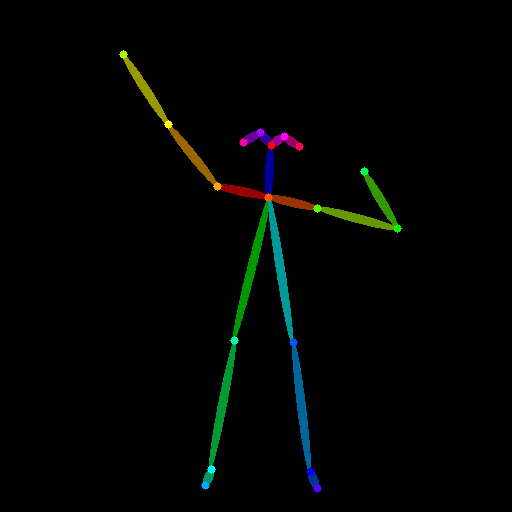

In [4]:
control_image

/home/unjun/Desktop/VSCode/MC949/T4/.venv/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:282: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Generating image 1/4...


100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Generating image 2/4...


100%|██████████| 25/25 [00:10<00:00,  2.40it/s]


Generating image 3/4...


100%|██████████| 25/25 [00:11<00:00,  2.22it/s]


Generating image 4/4...


100%|██████████| 25/25 [00:11<00:00,  2.17it/s]


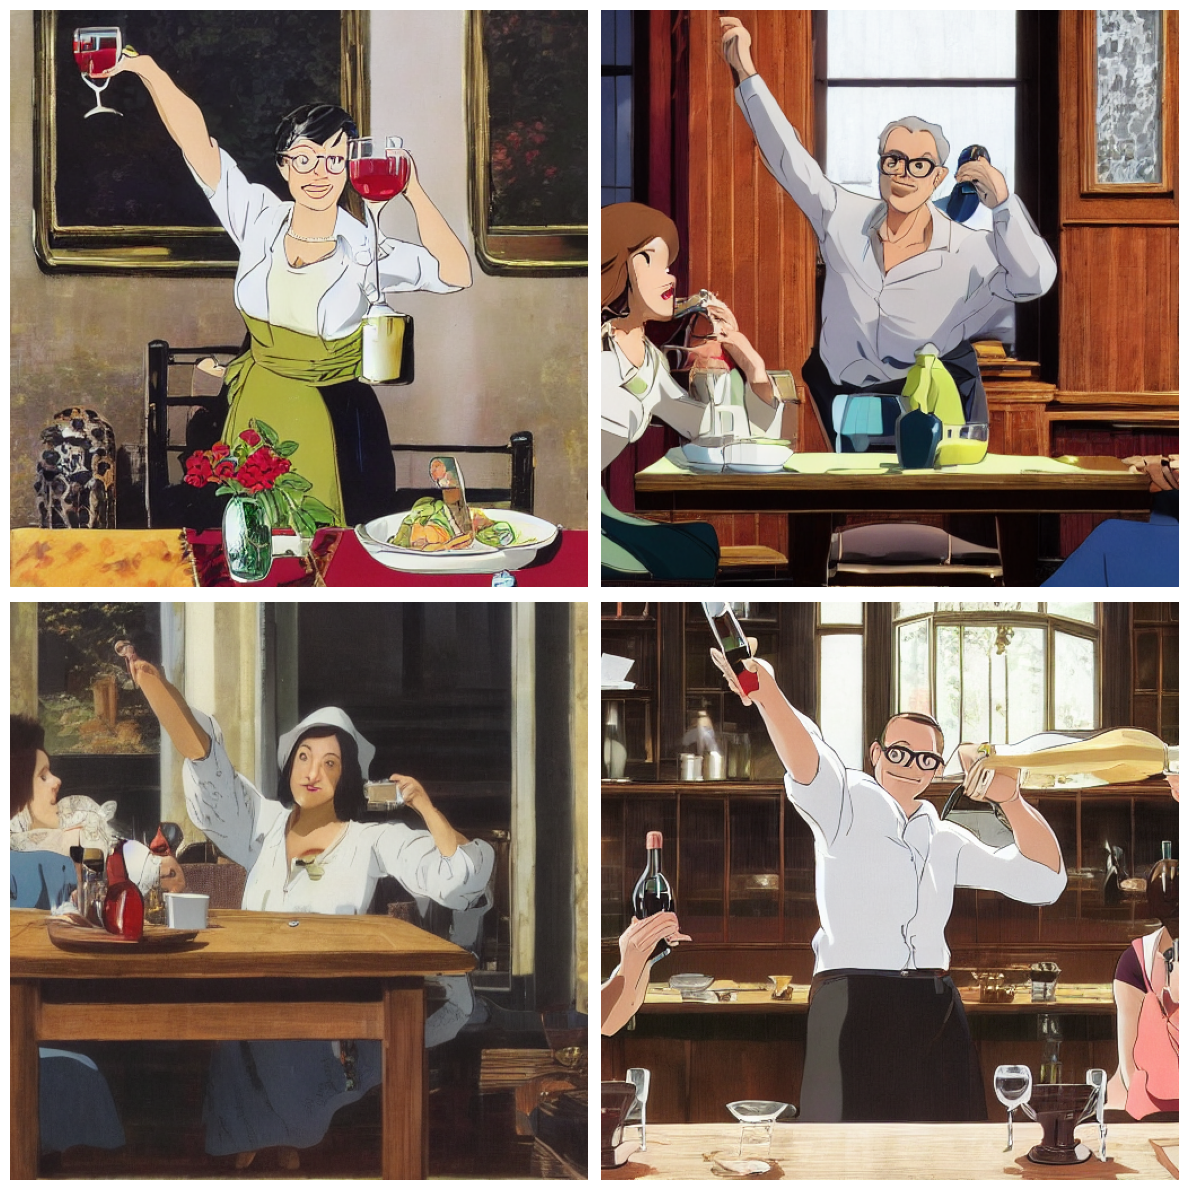

In [17]:
import matplotlib.pyplot as plt

pipeline.load_lora_weights("results_v1-5", weight_name="pytorch_lora_weights2.safetensors")


# Generate 4 images
images = []
for i in range(4):
    print(f"Generating image {i+1}/4...")
    image = pipeline(
        prompt="GBL, a man and a woman sitting at a table with glasses of wine in front of them.",
        negative_prompt="low quality, deformed, ugly, bad art, poorly drawn, bad anatomy, low detail, unrealistic",
        image=control_image,
        num_inference_steps=25,
        guidance_scale=5,
        controlnet_conditioning_scale=0.9, 
        generator=torch.Generator("cuda").manual_seed(100 + i)  # Different seed for each image
    ).images[0]
    images.append(image)

# Display all 4 images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, (ax, img) in enumerate(zip(axes.flat, images)):
    ax.imshow(img)
    # ax.set_title(f"Image {i+1} (seed: {42+i})")
    ax.axis('off')

plt.tight_layout()
plt.show()
